In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import plotly.graph_objects as go

sns.set(rc={'figure.figsize':(20,7.27)})

In [2]:
# Read the dataset
df = pd.read_excel('GOLD Price.xlsx', index_col=0)

In [3]:
# Setting a date as an index 
df.index = pd.to_datetime(df.index)
df.head()

,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,
2022-04-06,"1,916.70","1,931.80","1,916.70","1,918.40","1,918.40",412
2022-04-05,"1,927.10","1,943.50","1,918.40","1,922.90","1,922.90",412
2022-04-04,"1,921.20","1,936.10","1,915.60","1,929.20","1,929.20",371
2022-04-01,"1,935.00","1,938.00","1,917.00","1,919.10","1,919.10",1.016
2022-03-31,"1,933.50","1,949.90","1,919.10","1,949.20","1,949.20",3.617


In [4]:
# Cleaning the data
df = df[df.Open != '-']
df['Volume'] = df['Volume'].astype(str)
Volume = df['Volume'].str.replace('-', '0').astype(float)

# Replace comma
df = df.iloc[:, :-1].apply(lambda x: x.str.replace(',','')).astype('float')
# astype(str).str.replace('.', '') 
df['Volume'] = Volume.astype(int)
# reverse df
df = df.iloc[::-1]
df.head()

,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,
2017-04-07,1249.5,1269.1,1249.5,1254.3,1254.3,445
2017-04-10,1252.7,1255.2,1246.8,1251.1,1251.1,182
2017-04-11,1254.5,1273.5,1254.5,1271.2,1271.2,401
2017-04-12,1275.0,1285.1,1272.0,1275.3,1275.3,492
2017-04-13,1285.3,1287.6,1282.0,1285.9,1285.9,915


In [5]:
df.describe()

,Open,High,Low,Close*,Adj Close**,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,1533.259333,1540.239317,1526.280620,1533.381334,1533.381334,195.756156
std,258.933499,261.904130,256.106025,259.123424,259.123424,239.075448
min,1173.200000,1180.200000,1161.400000,1176.200000,1176.200000,0.000000
25%,1285.400000,1288.450000,1282.550000,1285.850000,1285.850000,16.000000
50%,1487.200000,1493.500000,1481.000000,1488.000000,1488.000000,89.000000
75%,1791.400000,1798.300000,1784.000000,1792.350000,1792.350000,301.500000
max,2053.600000,2072.000000,2040.000000,2051.500000,2051.500000,997.000000


### 1. Describe
1. Count number of non-null observations contains each column, overall there are 1259 observations and there are no null after cleaning 
2. Mean of Close and Adj Close columns is the same, that means they have identical data, it shows other <br> parameters too. Mean is higher than median (50%tile), its usually indicates that the data is <b>right skewed. </b> Average mean of Low column is lower than others which expectable.
3. A large standard deviation indicates that there is a lot of variance in the observed data around the mean. This indicates that the data observed is quite spread out. The high std also shows assets volatility.
4. 25% of data lays beneath in certain value of each columns, 50 percentile is the same as a median and <br>
75% of data lays below 75 percentile
5. Min, max shows maximum and minimum of values of each column. There are two times difference between min and max values. Max value of Open is higher than max value of Close column



### 2. Provide Exploratory Data Analysis

In [6]:
# There are no null values in df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-04-07 to 2022-04-06
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         1259 non-null   float64
 1   High         1259 non-null   float64
 2   Low          1259 non-null   float64
 3   Close*       1259 non-null   float64
 4   Adj Close**  1259 non-null   float64
 5   Volume       1259 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 63.9 KB


In [7]:
# We leave one column
df.rename(columns = {'Close*':'Close'}, inplace = True)
df_gold = df.copy()
df_gold = df_gold[['Close']]

#  We need business days and dont need holidays 
df_gold = df_gold.asfreq('b')

In [8]:
# Checking nan values
df_gold.isna().sum()

Close    45
dtype: int64

In [9]:
# There are several ways to fill nans, fill forward, bfill, value=df.column.mean()
# We'll use ffill method
df_gold = df_gold.fillna(method='ffill')

In [10]:
# Checking again to be sure that there are no nan values
df_gold.isna().sum()

Close    0
dtype: int64

In [11]:
# Plotting several boxplot to see clearly how golds action price
df_gold['year'] = [d.year for d in df_gold.index]
df_gold['month'] = [d.strftime('%b') for d in df_gold.index]
years = df_gold['year'].unique()

<AxesSubplot:xlabel='year', ylabel='Close'>

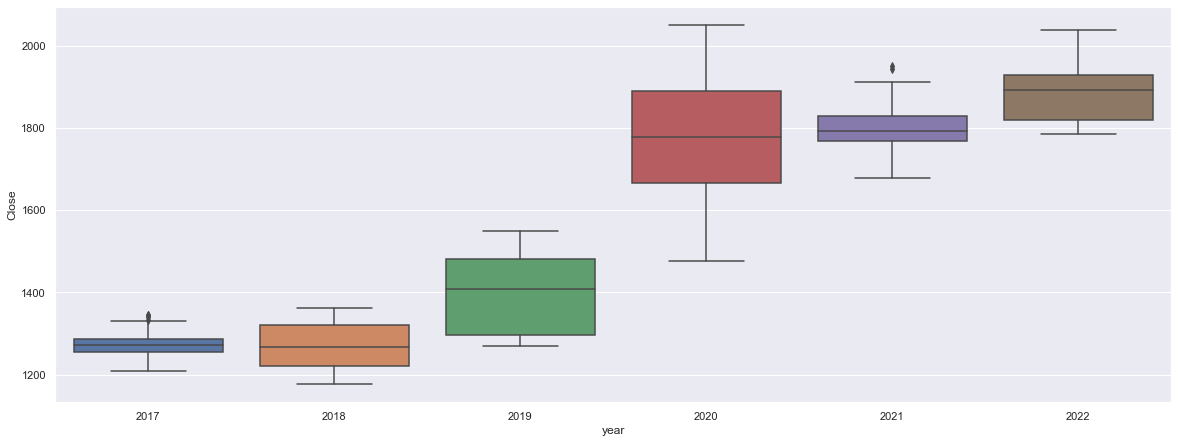

In [12]:
sns.boxplot(x='year', y='Close', data=df_gold)

We can see high volatility and strong uptrend in 2020 because of pandemmic. Investors mostly buys protected assets in crisis<br>
and some outliers in 2021 and 2017  

<AxesSubplot:xlabel='month', ylabel='Close'>

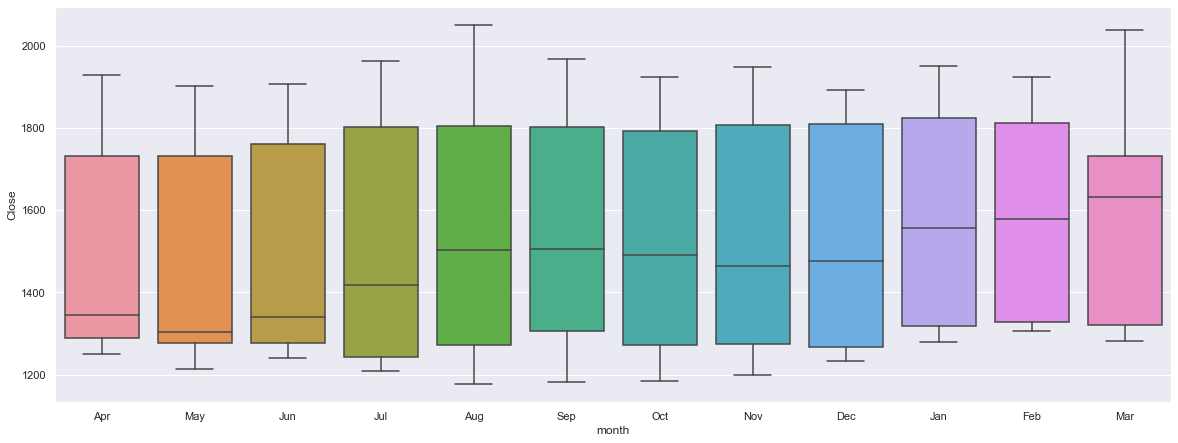

In [13]:
sns.boxplot(x='month', y='Close', data=df_gold)

Here we can see that in third quater and first quater gold prices (median, mean) is higher than other periods

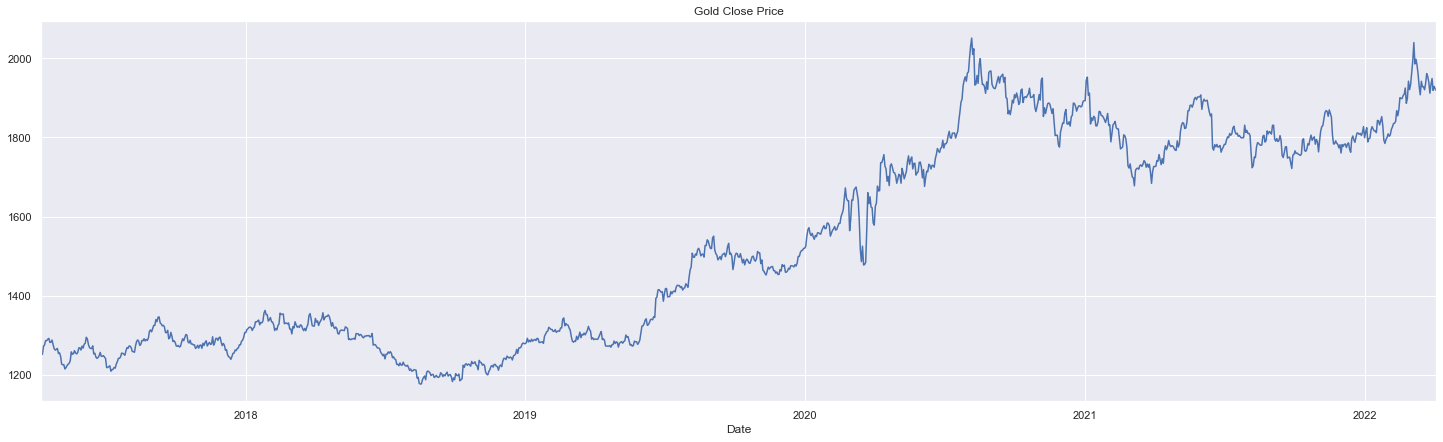

In [14]:
# How actiually our dataset looks like
df_gold.Close.plot(figsize=(25,7), title='Gold Close Price');

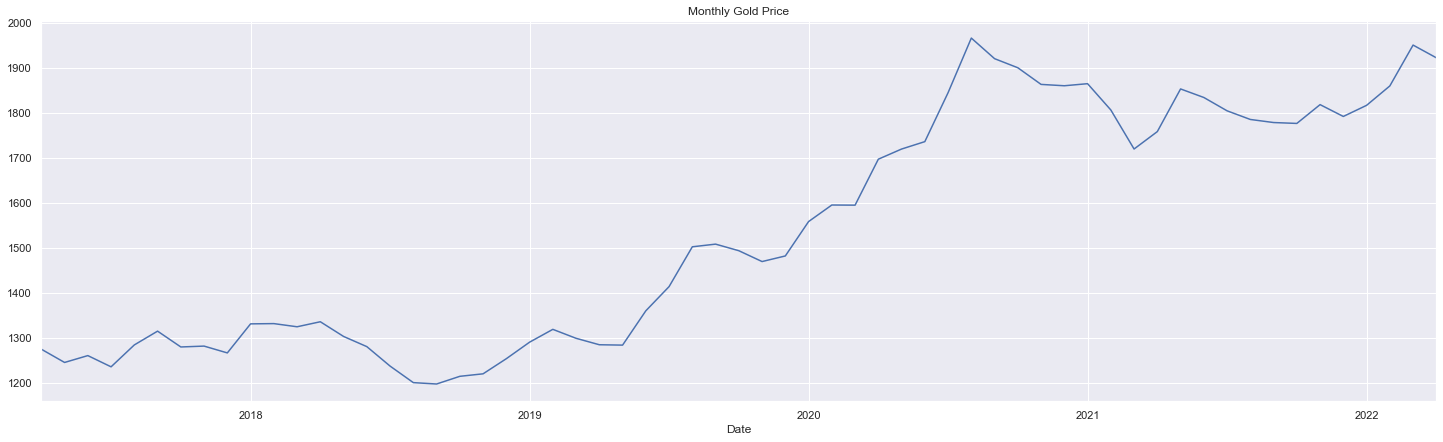

In [15]:
# We can try resample our data, to see is there any trend clearly
df_month = df_gold.resample("MS").mean().Close
df_month.plot(figsize=(25,7), title='Monthly Gold Price');

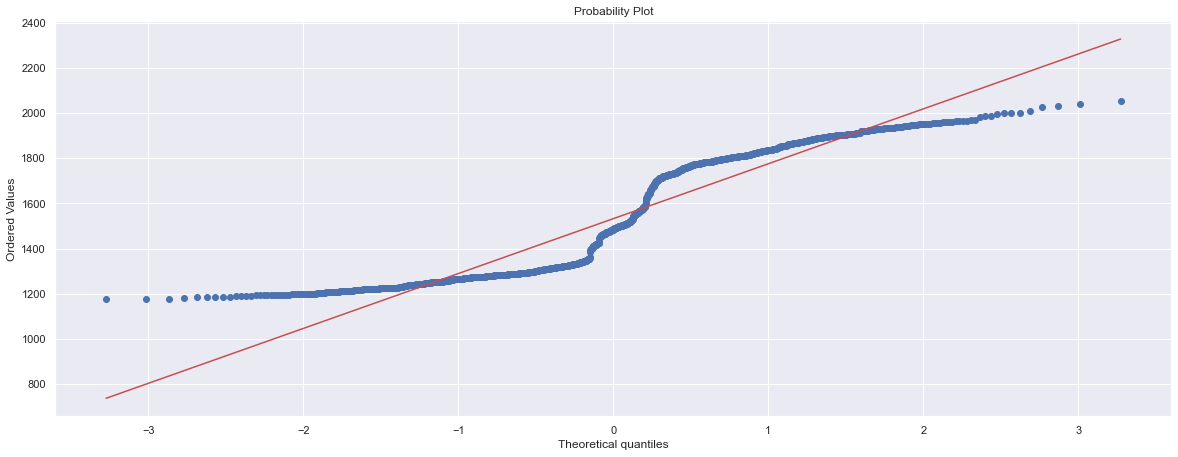

In [16]:
# QQPLot show us is our dataset normally distributed
from scipy import stats
import pylab

# We can see that our data is not normally distributed
stats.probplot(df_gold.Close, plot=pylab)
pylab.show()

### 3. Season, trend, autocorrelation, stationarity

#### Seasonality

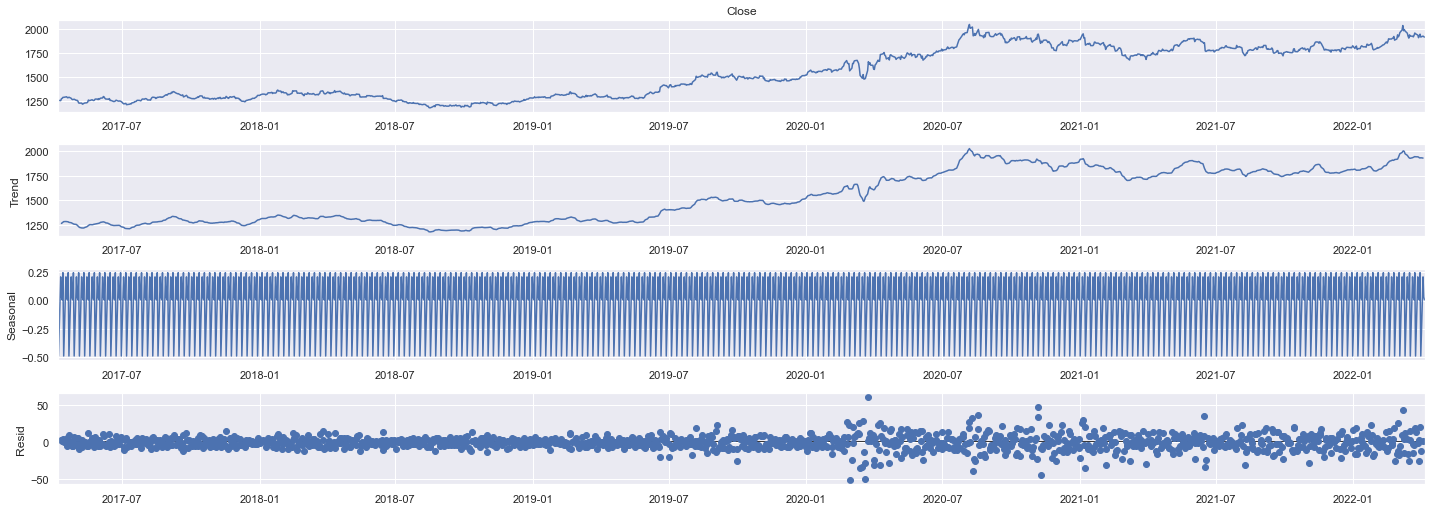

In [17]:
s_dec_additive = seasonal_decompose(df_gold.Close, model='additive')
s_dec_additive.plot()
plt.show()

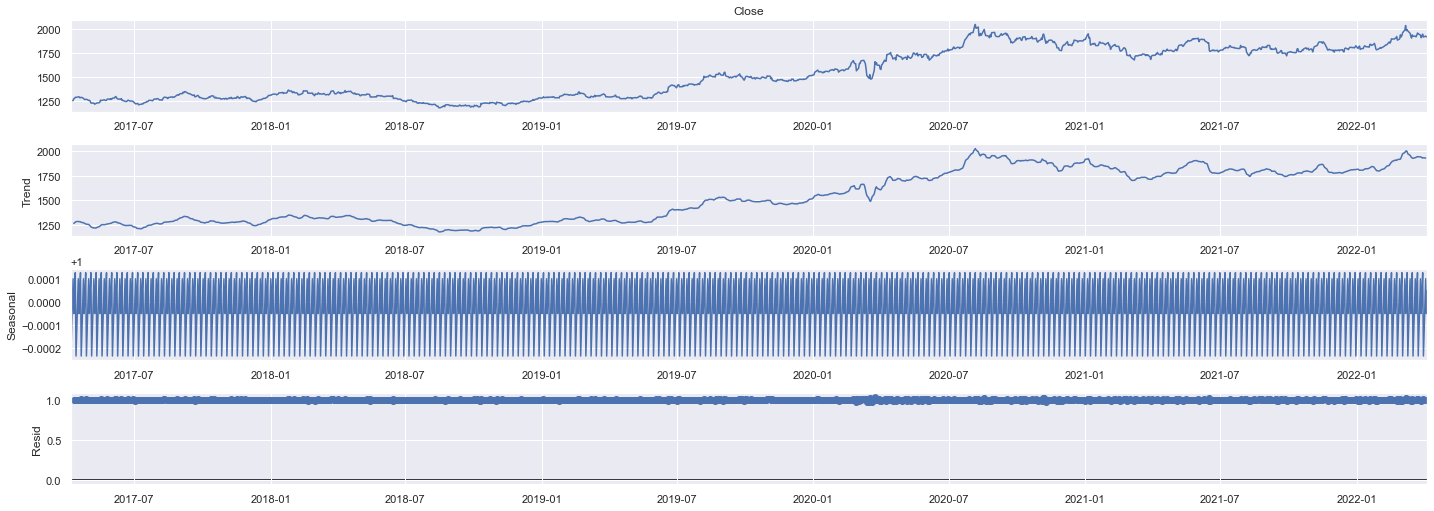

In [18]:
s_dec_multiplicative = seasonal_decompose(df_gold.Close, model='multiplicative')
s_dec_multiplicative.plot()
plt.show()

There is no concrete cyclical pattern detemine by using naive decomposition (no seasonality).

#### Staionarity

In [19]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(df):
    result = adfuller(df)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [20]:
# Our data is not staitionary
adfuller_test(df_gold.Close)

ADF Test Statistic : -0.4242600682848881
p-value : 0.9059687362265911
#Lags Used : 6
Number of Observations Used : 1297
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [21]:
# Rejected null hypotesis, time series is not stationary
import statsmodels.api as sm

#perform KPSS test
sm.tsa.stattools.kpss(df_gold.Close, regression='ct')

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(0.6105992897234053,
 0.01,
 21,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

#### ACF

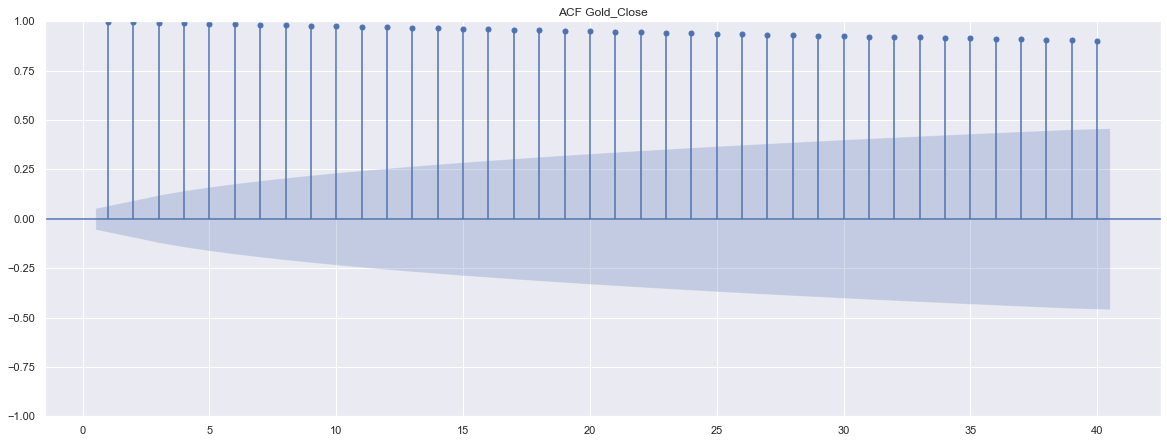

In [22]:
plot_acf(df_gold.Close, lags=40 , zero=False)
plt.title('ACF Gold_Close')
plt.show()

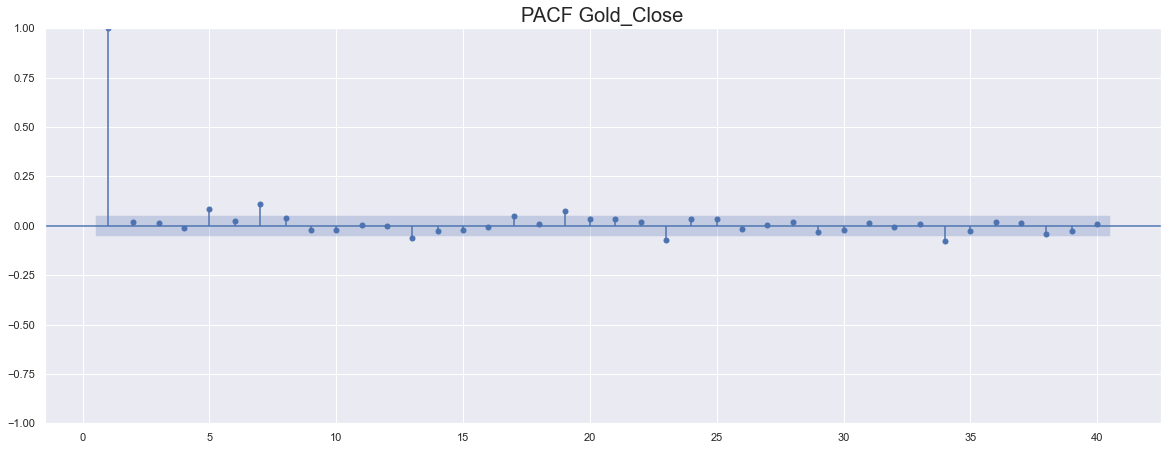

In [23]:
# Direct relationship between time series and its lag version we need compute Partial autocorrelation (PACF)
plot_pacf(df_gold.Close, lags=40, zero=False, method=('ols'))
plt.title('PACF Gold_Close', size=20)
plt.show()

Coefficients  are sigificant which is indicate time dependece in data 

### 4. Construct models with different time series models

##### a) Simple linear model

In [24]:
# # Only close data we need
# df_gold = df_gold.Close

In [25]:
# Calculating how our model actually predicting good
# Is the error of predicted model within one standard error away from the mean
def statistics(test_, pred):
    print('RMSE of between predicted model and test: ', round(np.sqrt(mean_squared_error(test_, pred)),2))
    print('MAPE of between predicted model and test: ', round(mean_absolute_percentage_error(test_, pred),2))
    print(f'Mean: {df_gold.Close.mean()} \nStandard deviation: {np.sqrt(df_gold.Close.var())}')

In [26]:
X = np.arange(0,len(df_gold.Close), 1)
#train_test_split 80/20
X_test = X[1043:].reshape(-1,1)
X_train = X[:1043].reshape(-1,1)
y_train = df_gold.Close[:1043]
y_test = df_gold.Close[1043:]

X_forecast = X.reshape(-1,1)

In [27]:
lin_regression = LinearRegression().fit(X_train, y_train)
model_line = lin_regression.predict(X_test)

In [28]:
def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction
    '''
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper


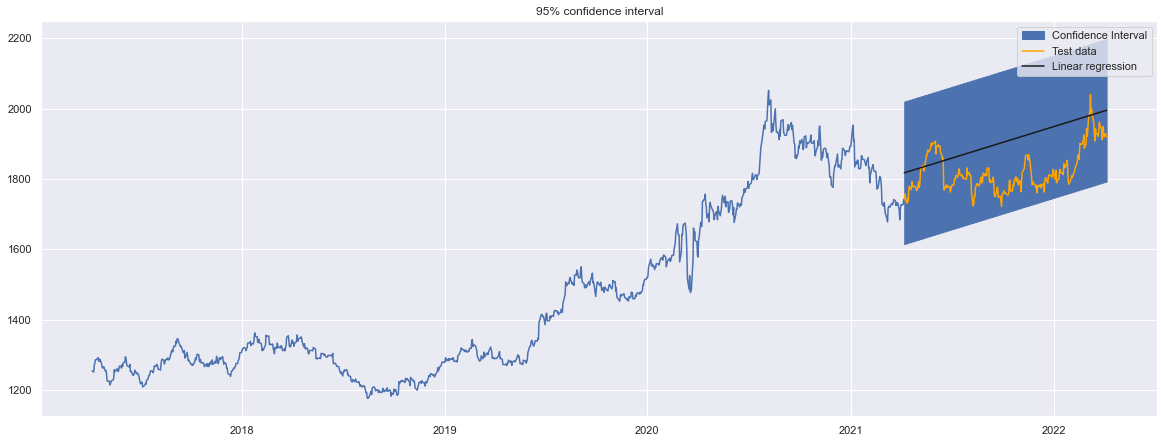

In [29]:
lower_vet = []
upper_vet = []

for i in model_line:
    lower, prediction, upper =  get_prediction_interval(i, y_test, model_line)
    lower_vet.append(lower)
    upper_vet.append(upper)

plt.fill_between(y_test.index,upper_vet, lower_vet, color='b',label='Confidence Interval')
plt.plot(y_test.index,y_test,color='orange',label='Test data')
plt.plot(y_test.index,model_line,'k',label='Linear regression')
plt.plot(y_train)
plt.title('95% confidence interval')
plt.legend(loc='best')
plt.show()

In [30]:
statistics(model_line, y_test)

RMSE of between predicted model and test:  102.89
MAPE of between predicted model and test:  0.05
Mean: 1532.5973159509203 
Standard deviation: 258.8414721518954


In [31]:
#Forecast 
lin_regression = LinearRegression().fit(X_forecast, df_gold.Close)
next_5 = np.arange(len(X_forecast),len(X_forecast)+5).reshape(-1,1)
next_10 = np.arange(len(X_forecast),len(X_forecast)+10).reshape(-1,1)
next_15 = np.arange(len(X_forecast),len(X_forecast)+15).reshape(-1,1)
model_line_next5 = lin_regression.predict(next_5)
model_line_next10 = lin_regression.predict(next_10)
model_line_next15 = lin_regression.predict(next_15)


C:\Users\User\AppData\Local\Temp/ipykernel_10360/427111968.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.1, 0.1, 0.1, 1)). The keyword argument will take precedence.
  plt.plot(next_5, model_line_next5,'k',label='next 5', color='black')
C:\Users\User\AppData\Local\Temp/ipykernel_10360/427111968.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.1, 0.1, 0.1, 1)). The keyword argument will take precedence.
  plt.plot(next_10, model_line_next10,'k',label='next 10', color='red')
C:\Users\User\AppData\Local\Temp/ipykernel_10360/427111968.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.1, 0.1, 0.1, 1)). The keyword argument will take precedence.
  plt.plot(next_15, model_line_next15,'k',label='next 15', color='b')


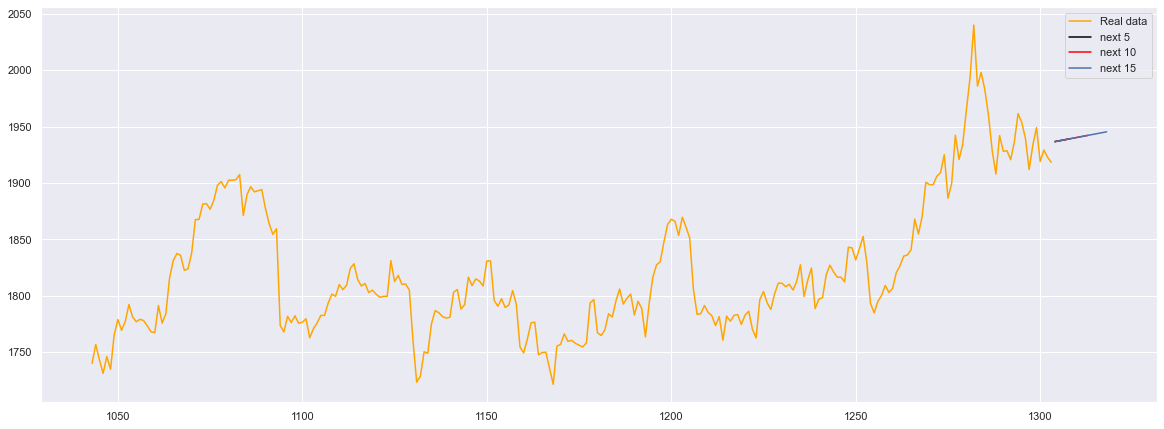

In [32]:
plt.plot(X_test,y_test,color='orange',label='Real data')
plt.plot(next_5, model_line_next5,'k',label='next 5', color='black')
plt.plot(next_10, model_line_next10,'k',label='next 10', color='red')
plt.plot(next_15, model_line_next15,'k',label='next 15', color='b')
plt.legend()
plt.show()

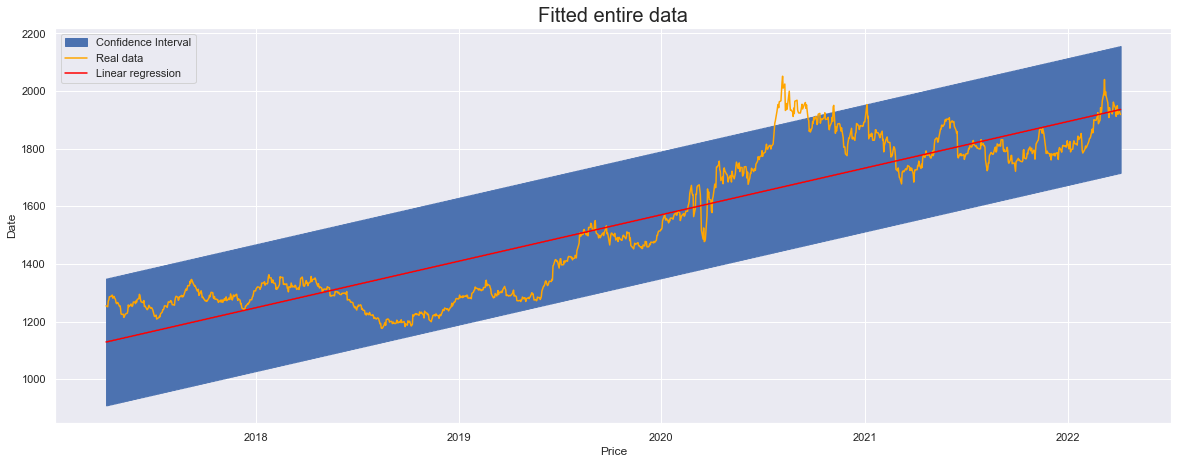

In [33]:
## Plot and save confidence interval of linear regression  - 95%
entire_data_reg = LinearRegression().fit(X_forecast, df_gold.Close)
entire_model_line = entire_data_reg.predict(X_forecast)
lower_vet = []
upper_vet = []

for i in entire_model_line:
    lower, prediction, upper =  get_prediction_interval(i, df_gold.Close, entire_model_line)
    lower_vet.append(lower)
    upper_vet.append(upper)

plt.fill_between(df_gold.index, upper_vet, lower_vet, color='b',label='Confidence Interval')
plt.plot(df_gold.index,df_gold.Close,color='orange',label='Real data')
plt.plot(df_gold.index,entire_model_line,'red',label='Linear regression')
plt.xlabel('Price')
plt.ylabel('Date')
plt.title('Fitted entire data', size=20)
plt.legend()
plt.show()

#### 4. Exponential Smoothing

In [34]:
# Spliting data into test and train datasets
size = int(len(df_gold.Close)*0.8)
train, test = df_gold.Close[0:size], df_gold.Close[size: len(df_gold)]

#Setting start and end dates
start_date = '2021-04-07'
end_date = '2022-04-06'

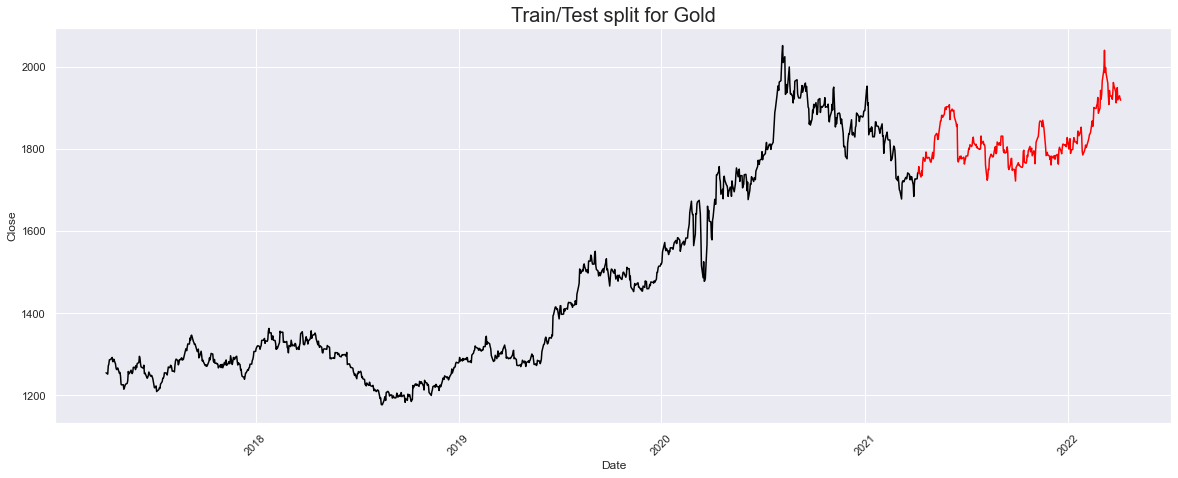

In [35]:
# Plot our splitted data
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Gold", size=20)
plt.show()

In [36]:
from statsmodels.tsa.api import ExponentialSmoothing

In [37]:
exp_model = ExponentialSmoothing (
    train,
    trend='mul',
).fit(smoothing_level=0.45, smoothing_trend=0.1, optimized=False)

In [38]:
exp_predict = exp_model.predict(start=start_date, end=end_date)

261

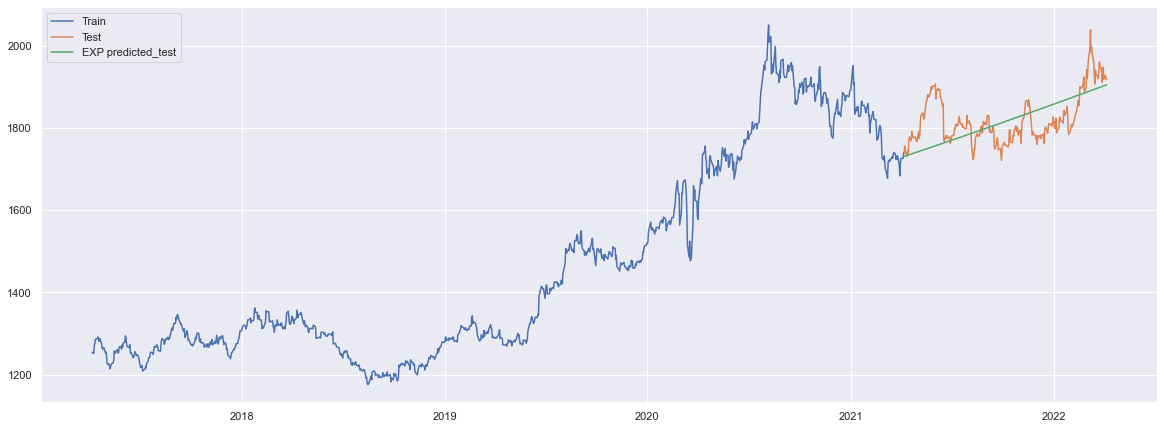

In [39]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(exp_predict, label='EXP predicted_test')
plt.legend(loc='best')
len(exp_predict)

In [40]:

statistics(test, exp_predict)

RMSE of between predicted model and test:  58.56
MAPE of between predicted model and test:  0.03
Mean: 1532.5973159509203 
Standard deviation: 258.8414721518954


In [41]:
exp_model_prediction=ExponentialSmoothing (
    df_gold.Close,
    trend='mul',
).fit()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [42]:
exp_next_5 = exp_model_prediction.forecast(5)
exp_next_10 = exp_model_prediction.forecast(10)
exp_next_15 = exp_model_prediction.forecast(15)

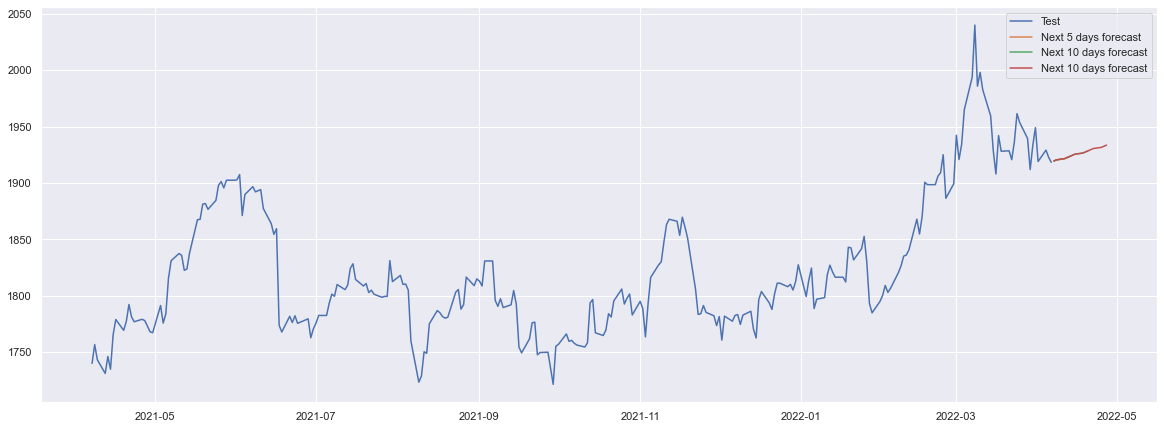

In [43]:
plt.plot(test, label='Test')
plt.plot(exp_next_5, label='Next 5 days forecast')
plt.plot(exp_next_10, label='Next 10 days forecast')
plt.plot(exp_next_15, label='Next 10 days forecast')
plt.legend(loc='best')

#### c) Autoregression (AR)

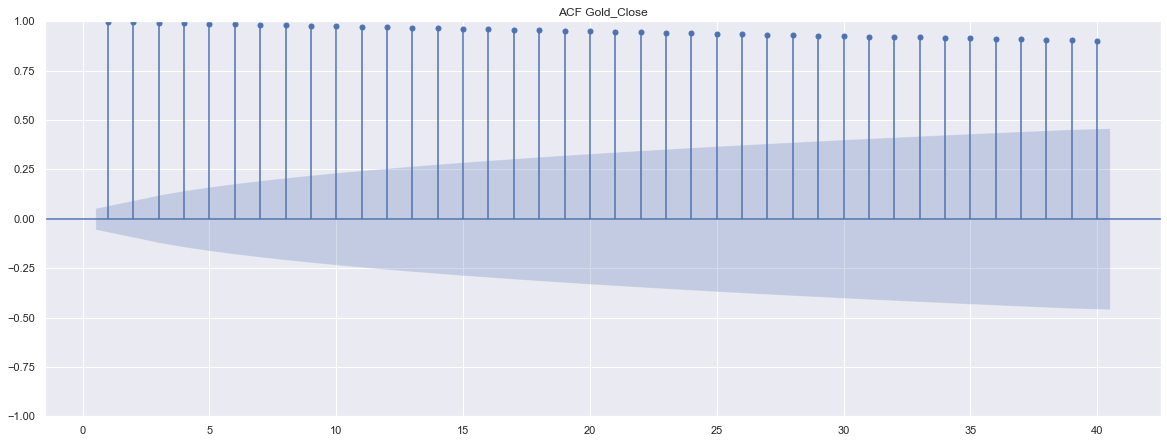

In [44]:
plot_acf(df_gold.Close, lags=40 , zero=False)
plt.title('ACF Gold_Close')
plt.show()

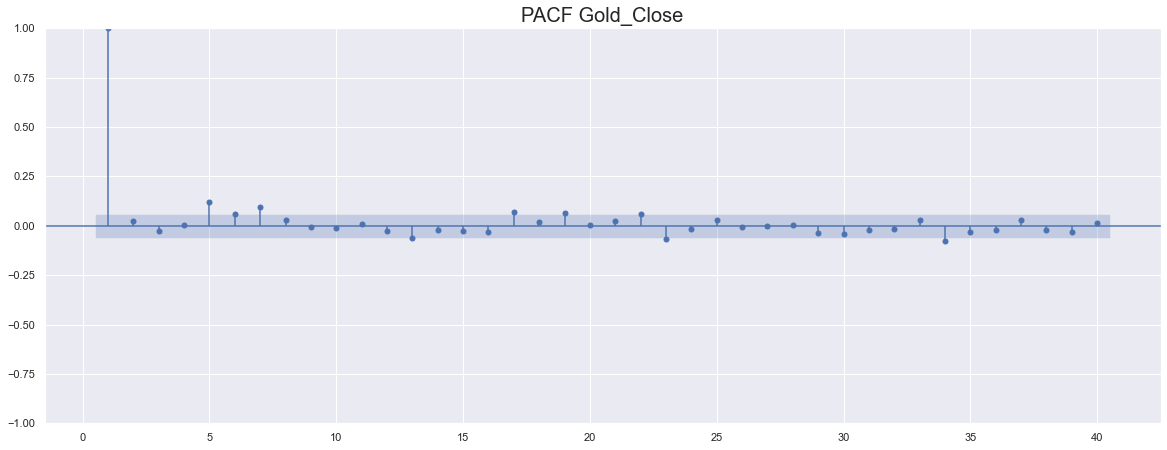

In [45]:
# To find a direct relationship between time series and its lag version we need compute Partial autocorrelation (PACF)
plot_pacf(train, lags=40, zero=False, method=('ols'))
plt.title('PACF Gold_Close', size=20)
plt.show()

In [46]:
# AR model
from statsmodels.tsa.ar_model import AutoReg

In [47]:
# Based on LLR test choose the lag=7, when we get p<0.05 and greater log-likelihood
# Last lag value not be significantly different from 0
model_ar = AutoReg(train, 7)
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1043
Model:                     AutoReg(7)   Log Likelihood               -4238.617
Method:               Conditional MLE   S.D. of innovations             14.475
Date:                Thu, 28 Apr 2022   AIC                           8495.233
Time:                        21:14:09   BIC                           8539.721
Sample:                    04-18-2017   HQIC                          8512.113
                         - 04-06-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9537      2.802      0.697      0.486      -3.539       7.446
Close.L1       0.9642      0.031     31.148      0.000       0.904       1.025
Close.L2       0.0517      0.043      1.201      0.230      -0.033       0.136
Close.L3      -0.0243      0.043     -0.565      0.572      -0.109       0.060
Close.L4      -0.1109      0.043     -2.583      0.010      -0.195      -0.027
Close.L5       0.0579      0.043      1.343      0.179      -0.027       0.142
Close.L6      -0.0319      0.043     -0.737      0.461      -0.117       0.053
Close.L7       0.0924      0.031      2.975      0.003       0.032       0.153
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           -0.0000j            1.0007           -0.0000
AR.2            1.0968           -0.7733j            1.3420           -0.0977
AR.3            1.0968           +0.7733j            1.3420            0.0977
AR.4           -1.2648           -0.7939j            1.4933           -0.4108
AR.5           -1.2648           +0.7939j            1.4933            0.4108
AR.6           -0.1600           -1.6333j            1.6411           -0.2655
AR.7           -0.1600           +1.6333j            1.6411            0.2655
-----------------------------------------------------------------------------
"""

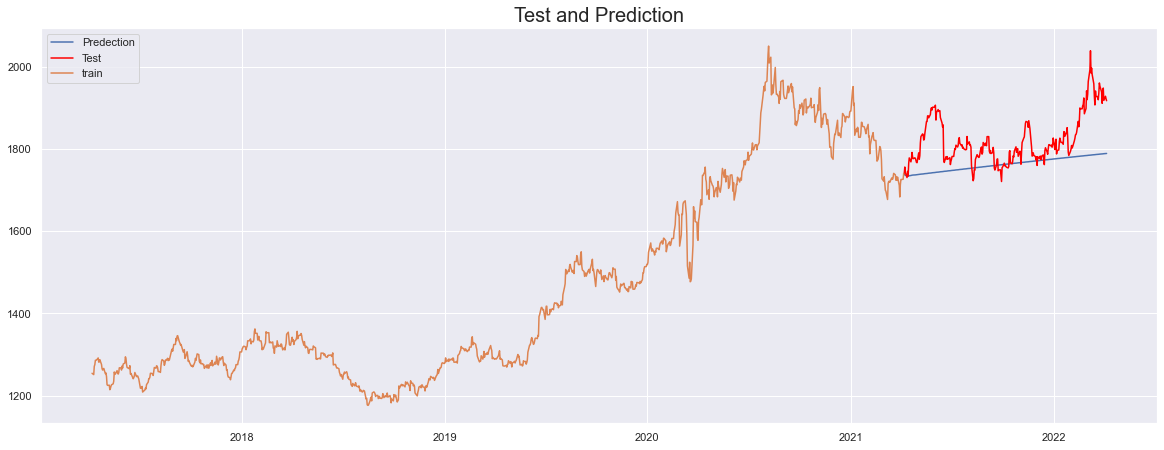

In [48]:
ar_resulst_model = results_ar.predict(start=start_date, end=end_date)
plt.plot(ar_resulst_model, label='Predection')
plt.plot(test, color='red', label='Test')
plt.plot(train, label='train')
plt.title('Test and Prediction', size=20)
plt.legend(loc='best')

In [49]:
statistics(test, ar_resulst_model)

RMSE of between predicted model and test:  80.44
MAPE of between predicted model and test:  0.03
Mean: 1532.5973159509203 
Standard deviation: 258.8414721518954


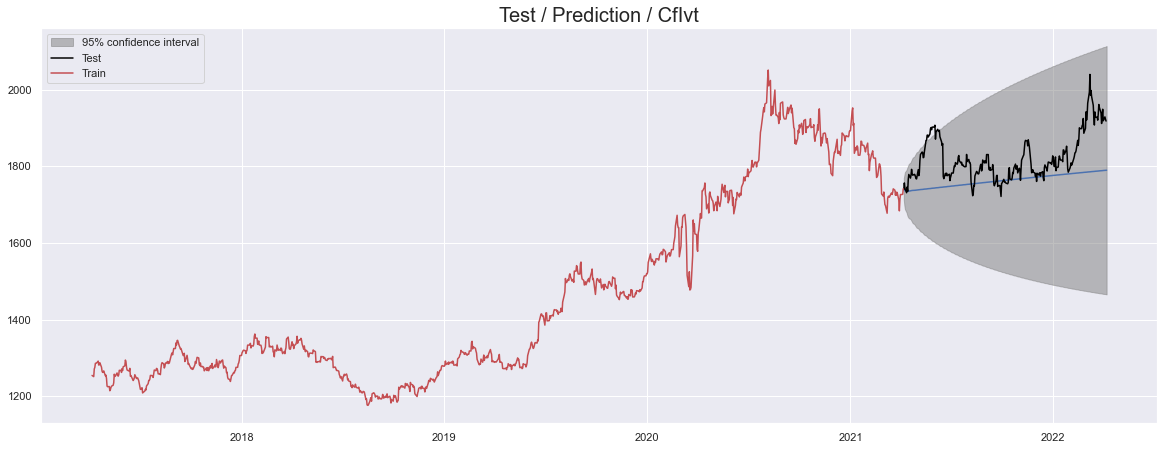

In [50]:
results_ar.plot_predict(1043,1304)
plt.plot(test, color='black', label='Test')
plt.plot(train, color='r', label='Train')
plt.title('Test / Prediction / CfIvt', size=20)
plt.legend(loc='best')

In [51]:
# Testing how parameters fit the model
from scipy.stats.distributions import chi2
# DF is degrees of freedom
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p


In [52]:
# Forecast
model_ar_forecast = AutoReg(df_gold.Close, 5)
results_ar_results = model_ar_forecast.fit()
results_ar_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1304
Model:                     AutoReg(5)   Log Likelihood               -5363.310
Method:               Conditional MLE   S.D. of innovations             15.027
Date:                Thu, 28 Apr 2022   AIC                          10740.619
Time:                        21:14:11   BIC                          10776.805
Sample:                    04-14-2017   HQIC                         10754.197
                         - 04-06-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0107      2.512      0.801      0.423      -2.912       6.934
Close.L1       0.9805      0.028     35.476      0.000       0.926       1.035
Close.L2       0.0025      0.039      0.064      0.949      -0.073       0.078
Close.L3       0.0246      0.039      0.635      0.525      -0.051       0.100
Close.L4      -0.0950      0.039     -2.453      0.014      -0.171      -0.019
Close.L5       0.0865      0.028      3.125      0.002       0.032       0.141
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0009           -0.0000j            1.0009           -0.0000
AR.2           -1.2617           -1.3045j            1.8148           -0.3723
AR.3           -1.2617           +1.3045j            1.8148            0.3723
AR.4            1.3103           -1.3376j            1.8724           -0.1266
AR.5            1.3103           +1.3376j            1.8724            0.1266
-----------------------------------------------------------------------------
"""

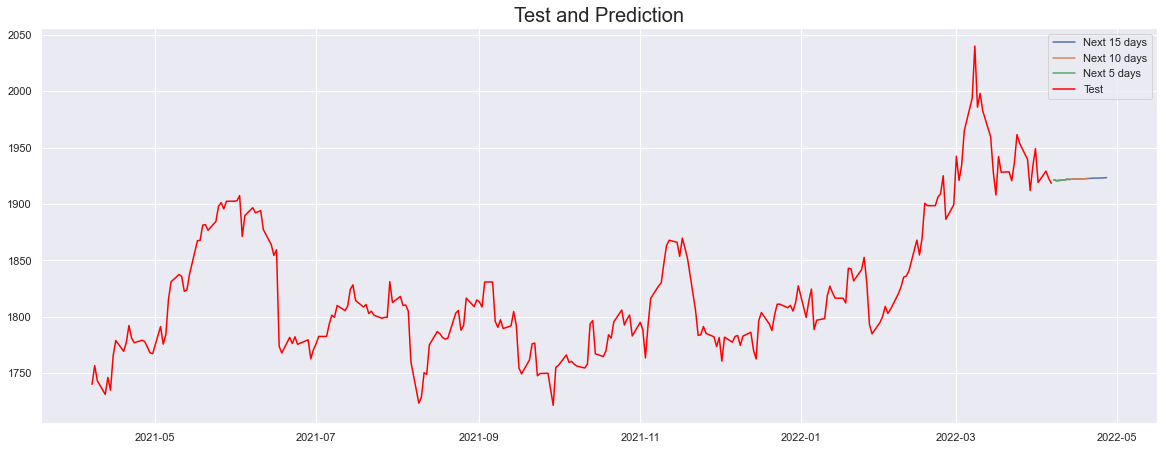

In [53]:
plt.plot(results_ar_results.forecast(15), label='Next 15 days')
plt.plot(results_ar_results.forecast(10), label='Next 10 days')
plt.plot(results_ar_results.forecast(5), label='Next 5 days')
plt.plot(test, color='red', label='Test')
plt.title('Test and Prediction', size=20)
plt.legend(loc='best')

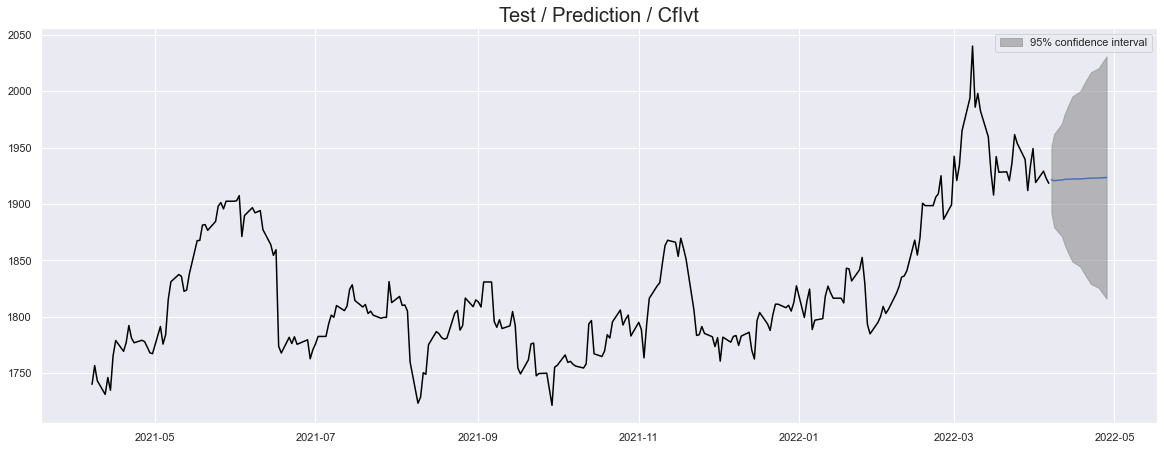

In [54]:
results_ar_results.plot_predict(1304,1319)
plt.plot(test, color='black')
plt.title('Test / Prediction / CfIvt', size=20);

#### d) Moving Average (MA)

In [55]:
# We know, that our data is not stationary that will impact to MA model 
# which predicting non stationary data porly
# We'll use returs inplace Close price
df_gold['returns'] = df_gold.Close.pct_change(1).mul(100)

df_gold = df_gold[1:]

In [56]:
# Now we get stationary data
adfuller_test(df_gold.returns)

ADF Test Statistic : -17.505327057858914
p-value : 4.363566306424369e-30
#Lags Used : 5
Number of Observations Used : 1297
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


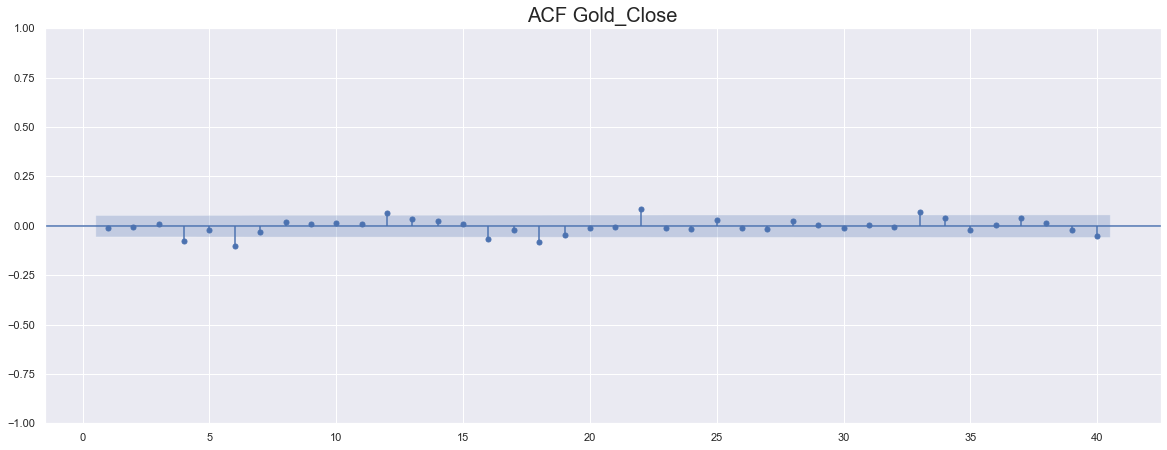

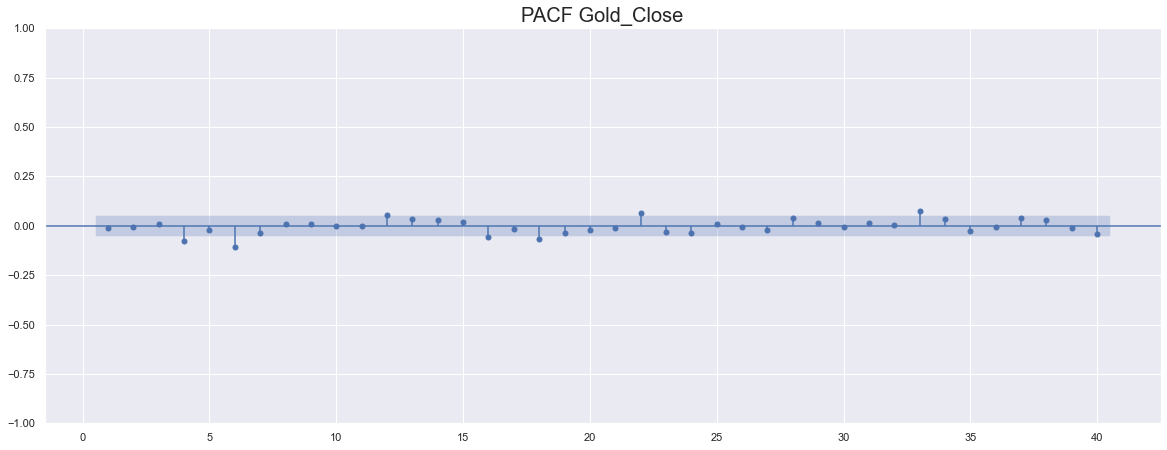

In [57]:
plot_acf(df_gold.returns, lags=40 , zero=False)
plt.title('ACF Gold_Close', size=20)
plt.show()

# Direct relationship between time series and its lag version we need compute Partial autocorrelation (PACF)
plot_pacf(df_gold.returns, lags=40, zero=False, method=('ols'))
plt.title('PACF Gold_Close', size=20)
plt.show()

In [58]:
# Spliting data into test and train datasets
size = int(len(df_gold.returns)*0.8)
train_s, test_s = df_gold.returns[0:size], df_gold.returns[size: len(df_gold.returns)]

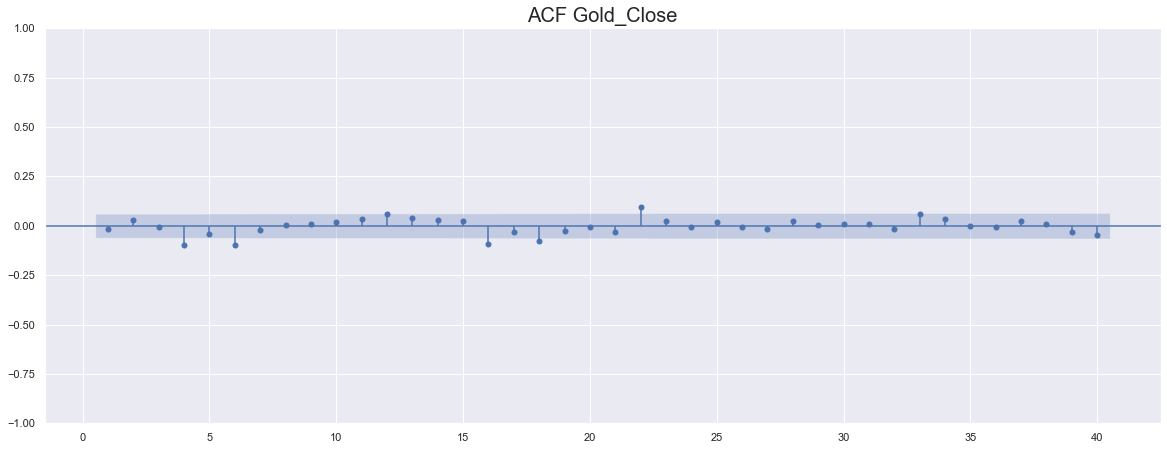

In [59]:
plot_acf(train_s, lags=40 , zero=False)
plt.title('ACF Gold_Close', size=20)
plt.show()

In [60]:
model_ret_ma_1 = ARIMA(train_s, order=(0,0,6))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1042
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -1370.492
Date:                Thu, 28 Apr 2022   AIC                           2756.984
Time:                        21:14:16   BIC                           2796.575
Sample:                    04-10-2017   HQIC                          2772.001
                         - 04-06-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0349      0.023      1.542      0.123      -0.009       0.079
ma.L1         -0.0263      0.022     -1.221      0.222      -0.069       0.016
ma.L2          0.0224      0.022      1.025      0.305      -0.020       0.065
ma.L3         -0.0058      0.024     -0.241      0.809      -0.053       0.041
ma.L4         -0.0948      0.023     -4.084      0.000      -0.140      -0.049
ma.L5         -0.0368      0.027     -1.381      0.167      -0.089       0.015
ma.L6         -0.0912      0.025     -3.623      0.000      -0.140      -0.042
sigma2         0.8126      0.020     39.892      0.000       0.773       0.853
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1615.48
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

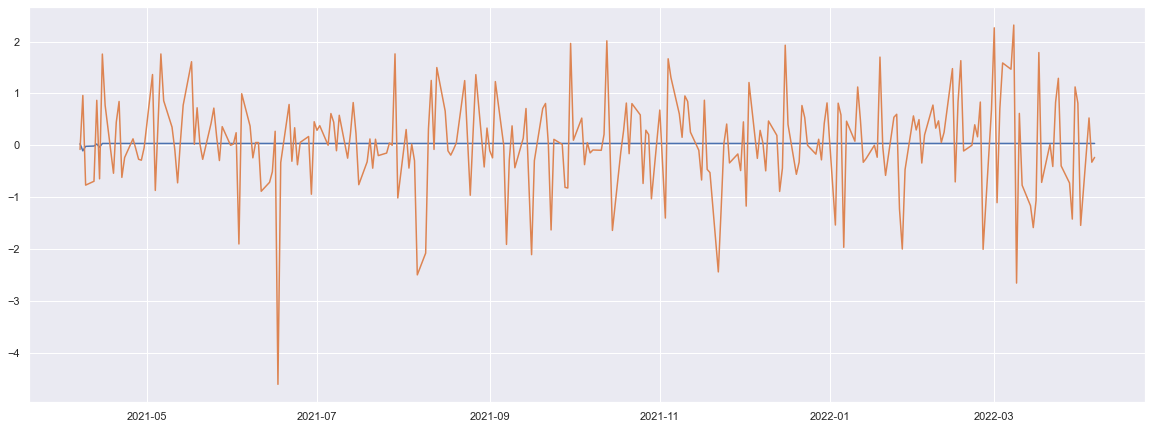

In [61]:
ret_results = results_ret_ma_1.predict(start=start_date, end=end_date)
plt.plot(ret_results)
plt.plot(test_s)

#### e) Autoregressive Moving Average (ARMA)

In [62]:
arma_model = ARIMA(train, order=(3,0,3))
arma_model_results = arma_model.fit()
arma_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1043
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -4268.825
Date:                Thu, 28 Apr 2022   AIC                           8553.650
Time:                        21:14:18   BIC                           8593.249
Sample:                    04-07-2017   HQIC                          8568.670
                         - 04-06-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1460.1759      0.001   2.62e+06      0.000    1460.175    1460.177
ar.L1          2.6152      0.035     74.187      0.000       2.546       2.684
ar.L2         -2.4931      0.069    -36.263      0.000      -2.628      -2.358
ar.L3          0.8779      0.036     24.708      0.000       0.808       0.948
ma.L1         -1.6604      0.042    -39.734      0.000      -1.742      -1.578
ma.L2          0.9543      0.051     18.537      0.000       0.853       1.055
ma.L3         -0.0829      0.022     -3.714      0.000      -0.127      -0.039
sigma2       208.4081      4.694     44.402      0.000     199.209     217.608
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2693.08
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               6.59   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.74e+19. Standard errors may be unstable.
"""

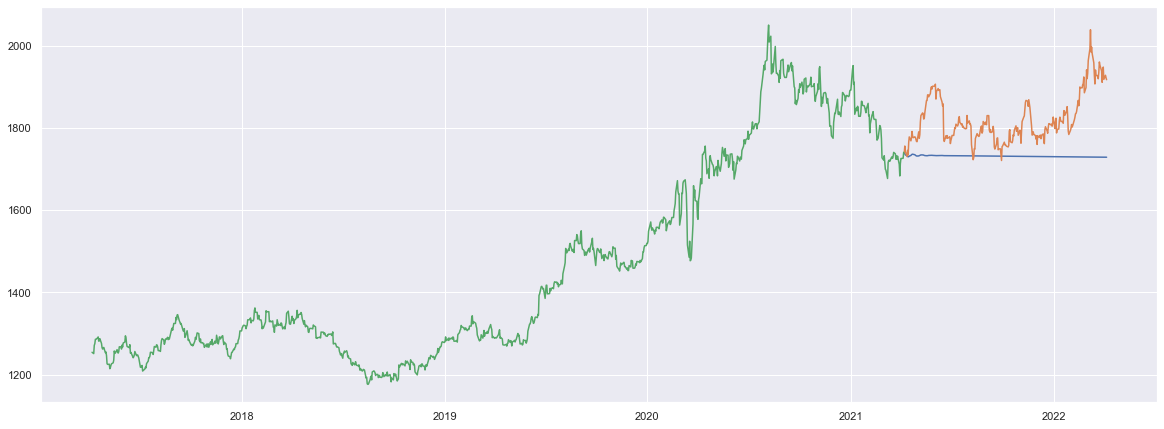

In [63]:
arma_result = arma_model_results.predict(start=start_date, end=end_date)
plt.plot(arma_result)
plt.plot(test)
plt.plot(train)

In [64]:
statistics(test, arma_result)

RMSE of between predicted model and test:  108.28
MAPE of between predicted model and test:  0.05
Mean: 1532.8108979278588 
Standard deviation: 258.8258788543134


In [65]:
arma_model_forecst = ARIMA(df_gold.Close, order=(3,0,2))
arma_model_frct = arma_model_forecst.fit()
arma_model_frct.summary()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1303
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -5383.102
Date:                Thu, 28 Apr 2022   AIC                          10780.204
Time:                        21:14:22   BIC                          10816.411
Sample:                    04-10-2017   HQIC                         10793.787
                         - 04-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1532.8121    243.111      6.305      0.000    1056.323    2009.301
ar.L1         -0.6151      0.069     -8.899      0.000      -0.751      -0.480
ar.L2          0.7331      0.031     23.358      0.000       0.672       0.795
ar.L3          0.8774      0.065     13.488      0.000       0.750       1.005
ma.L1          1.6002      0.078     20.576      0.000       1.448       1.753
ma.L2          0.8457      0.074     11.430      0.000       0.701       0.991
sigma2       225.9210      4.583     49.291      0.000     216.938     234.904
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2682.47
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               5.15   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

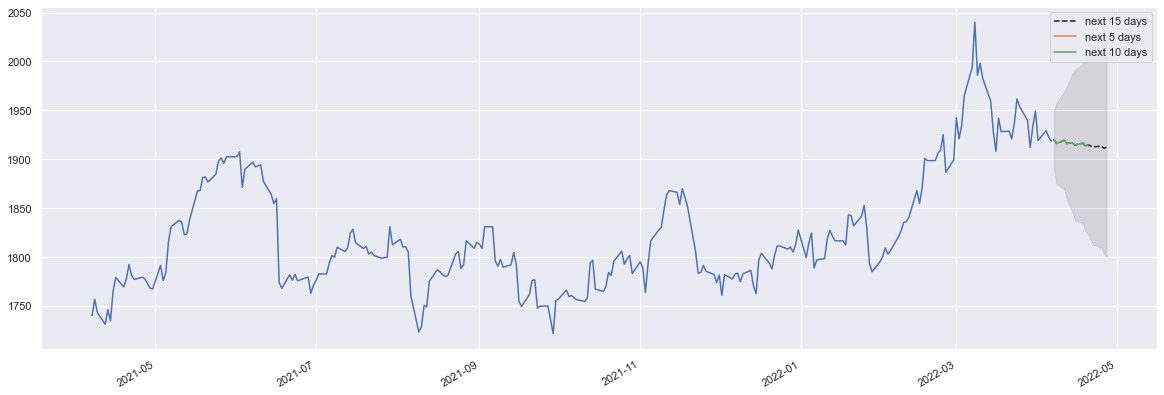

In [66]:
preds_next15 = arma_model_frct.get_forecast(15)
x = preds_next15.summary_frame()
fig, ax = plt.subplots(figsize=(20, 7))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
plt.plot(test)

# Construct the forecasts
x['mean'].plot(ax=ax, style='k--', label='next 15 days')
ax.fill_between(x.index, x['mean_ci_lower'], x['mean_ci_upper'], color='k', alpha=0.1);
plt.plot(arma_model_frct.forecast(5), label='next 5 days')
plt.plot(arma_model_frct.forecast(10), label='next 10 days')
plt.legend(loc='best')

#### f) Autoregressive Integrated Moving Average (ARIMA)

In [67]:
arima_model = ARIMA(train, order=(1,2,2))
arima_model_results = arima_model.fit()
arima_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1043
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -4274.957
Date:                Thu, 28 Apr 2022   AIC                           8557.914
Time:                        21:14:23   BIC                           8577.706
Sample:                    04-07-2017   HQIC                          8565.422
                         - 04-06-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9612      0.039    -24.477      0.000      -1.038      -0.884
ma.L1         -0.0272      0.047     -0.573      0.566      -0.120       0.066
ma.L2         -0.9726      0.045    -21.568      0.000      -1.061      -0.884
sigma2       214.5831      8.627     24.874      0.000     197.675     231.491
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):              3507.78
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               7.00   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

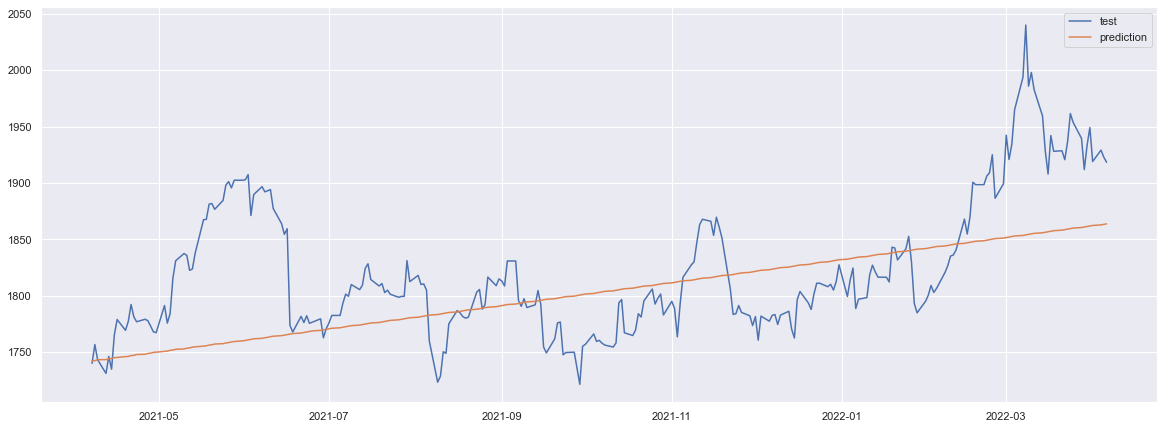

In [68]:
arima_results = arima_model_results.predict(start=start_date, end=end_date)
plt.plot(test, label='test')
plt.plot(arima_results, label='prediction')
plt.legend(loc='best')

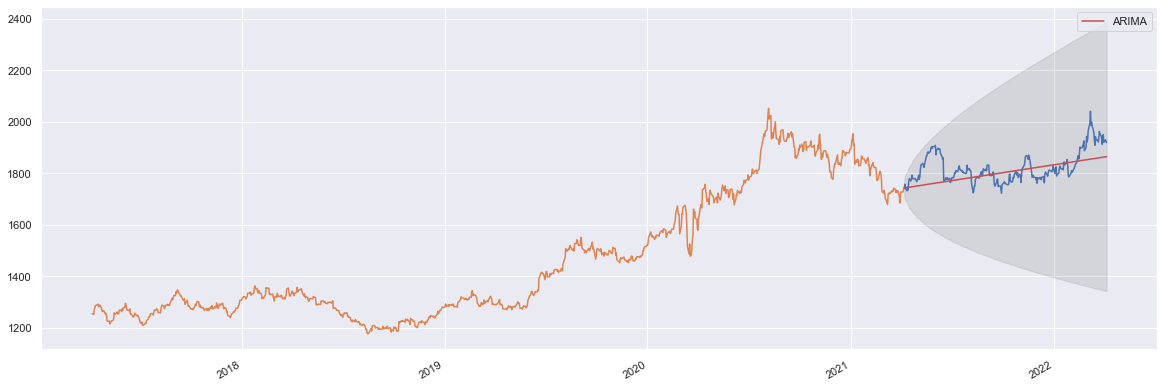

In [69]:
arima_results_invt = arima_model_results.get_forecast(len(test))
arima_forecasted = arima_results_invt.summary_frame()
fig, ax = plt.subplots(figsize=(20, 7))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
plt.plot(test)
plt.plot(train)

# Construct the forecasts
arima_forecasted['mean'].plot(ax=ax, style='r', label='ARIMA')
ax.fill_between(arima_forecasted.index, arima_forecasted['mean_ci_lower'], arima_forecasted['mean_ci_upper'], color='k', alpha=0.1);
plt.legend(loc='best')

In [70]:
statistics(test, arima_results)

RMSE of between predicted model and test:  57.44
MAPE of between predicted model and test:  0.02
Mean: 1532.8108979278588 
Standard deviation: 258.8258788543134


In [71]:
# Autoarima tuning (minimizing AIC) gives certain parameters
arima_model_forecast = ARIMA(df_gold.Close, order=(1,1,1))
arima_model_frct = arima_model_forecast.fit()
arima_model_frct.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1303
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5378.605
Date:                Thu, 28 Apr 2022   AIC                          10763.211
Time:                        21:14:25   BIC                          10778.726
Sample:                    04-10-2017   HQIC                         10769.031
                         - 04-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8405      0.072     11.738      0.000       0.700       0.981
ma.L1         -0.8775      0.064    -13.771      0.000      -1.002      -0.753
sigma2       226.8313      4.494     50.475      0.000     218.023     235.639
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):              2797.16
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               5.18   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

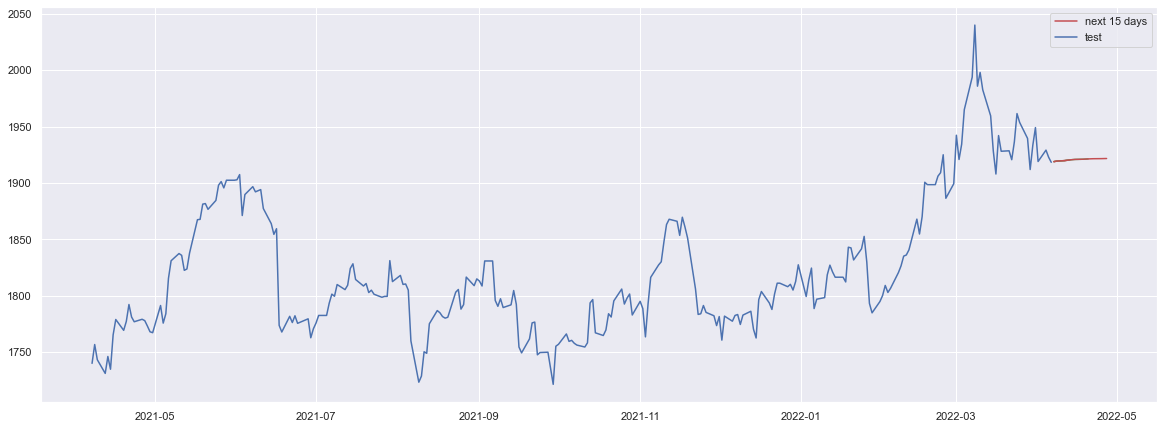

In [72]:
plt.plot(arima_model_frct.forecast(5),color='r')
plt.plot(arima_model_frct.forecast(10), color='g')
plt.plot(arima_model_frct.forecast(15), color='r', label='next 15 days')
plt.plot(test, label='test')
plt.legend(loc='best')

#### g) Seasonal Autoregressive Integrated Moving-Average (SARIMA)

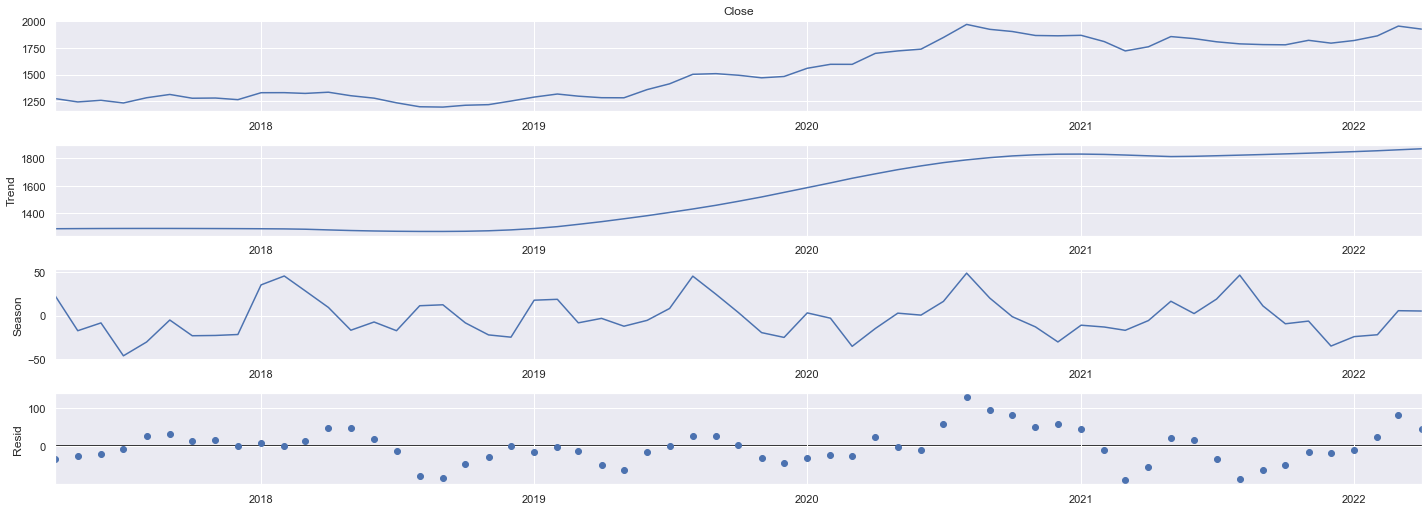

In [73]:
df_month = df_gold.Close.resample("MS").mean()
res = STL(df_month).fit()
res.plot()
plt.show()

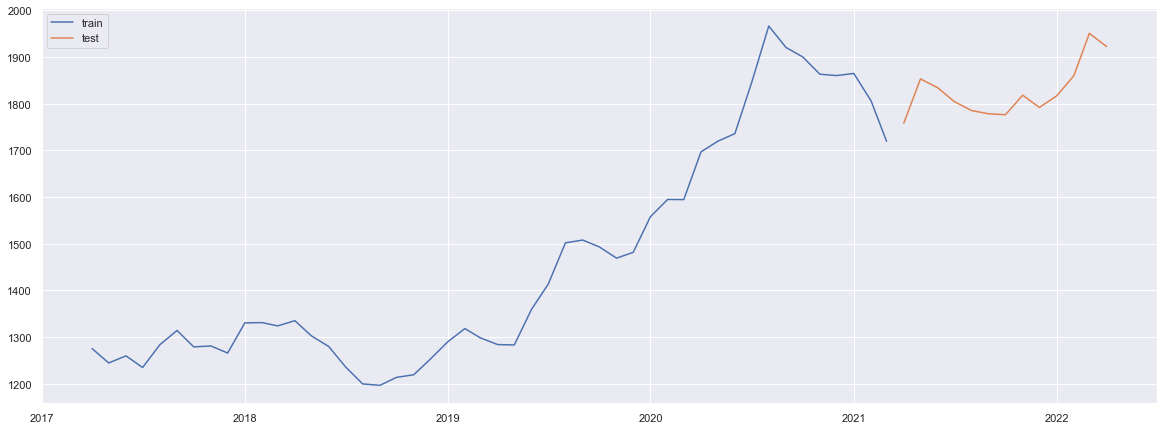

In [74]:
# Split dataset into train and test datasets
size = int(len(df_month)*0.8)
sar_train, sar_test = df_month[0:size], df_month[size: len(df_month)]
plt.plot(sar_train, label='train')
plt.plot(sar_test, label='test')
plt.legend()
plt.show()

In [75]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


sarima_model = SARIMAX (
        sar_train,
        order=(1,1,0),
        seasonal_order=(1,1,0,12)
)
                
sarima_result = sarima_model.fit()
sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -184.202
Date:                            Thu, 28 Apr 2022   AIC                            374.404
Time:                                    21:14:30   BIC                            379.070
Sample:                                04-01-2017   HQIC                           376.015
                                     - 03-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4742      0.168      2.821      0.005       0.145       0.804
ar.S.L12      -0.3882      0.219     -1.774      0.076      -0.817       0.041
sigma2      2046.8079    544.423      3.760      0.000     979.758    3113.857
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.87   Prob(JB):                         0.64
Heteroskedasticity (H):               2.30   Skew:                             0.34
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

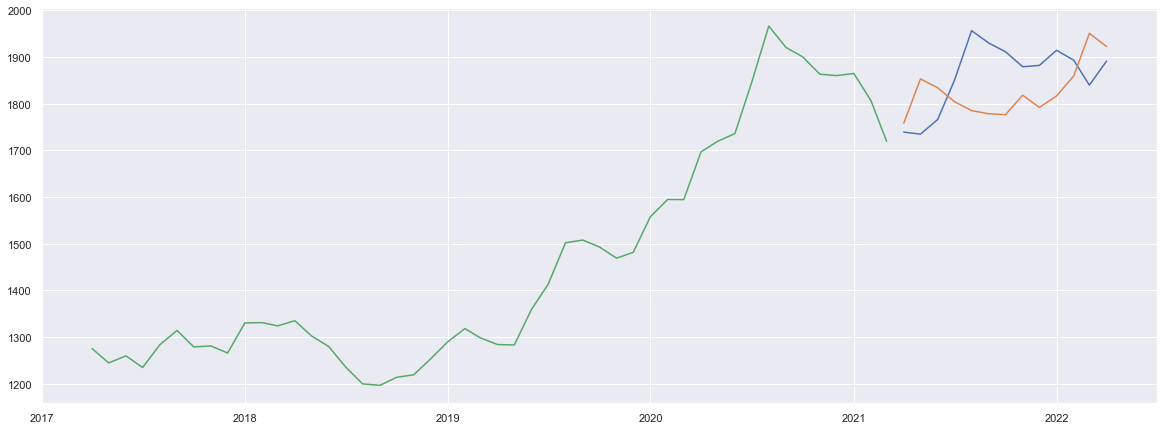

In [76]:
start_date1 = '2021-04-01'
end_date1 = '2022-04-01'
sarima_result_prediction = sarima_result.predict(start=start_date1, end=end_date1)
plt.plot(sarima_result_prediction)
plt.plot(sar_test)
plt.plot(sar_train)


In [77]:
statistics(sar_test, sarima_result_prediction)

RMSE of between predicted model and test:  98.92
MAPE of between predicted model and test:  0.05
Mean: 1532.8108979278588 
Standard deviation: 258.8258788543134


In [95]:
sarima_model_forecast = SARIMAX (
        df_month,
        order=(0,1,1),
        seasonal_order=(0,1,0,12)
)
                
sarima_result_frct = sarima_model_forecast.fit()
sarima_result_frct.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                   61
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -265.940
Date:                             Thu, 28 Apr 2022   AIC                            535.879
Time:                                     21:41:17   BIC                            539.621
Sample:                                 04-01-2017   HQIC                           537.293
                                      - 04-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3825      0.135      2.832      0.005       0.118       0.647
sigma2      3786.8179    951.415      3.980      0.000    1922.078    5651.558
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.87   Prob(JB):                         0.57
Heteroskedasticity (H):               2.56   Skew:                             0.21
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

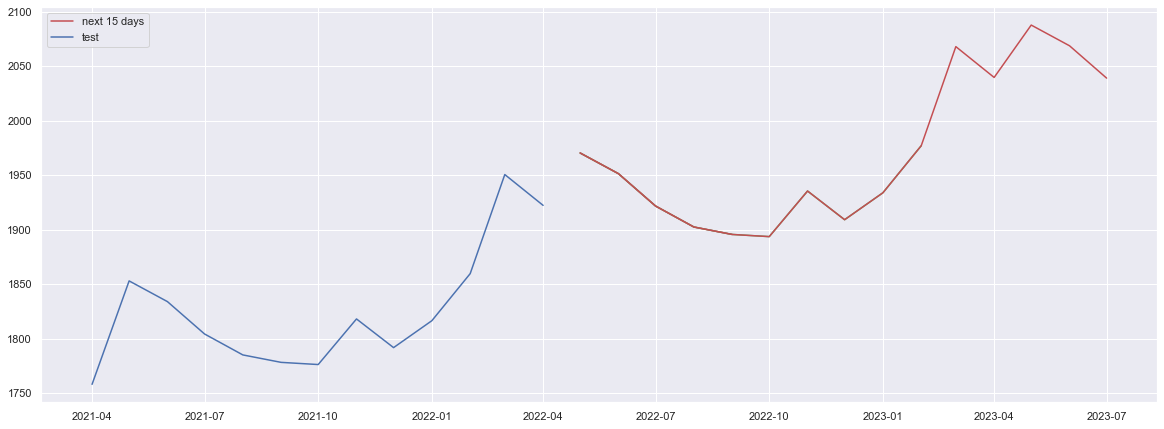

In [96]:
plt.plot(sarima_result_frct.forecast(5),color='r')
plt.plot(sarima_result_frct.forecast(10), color='g')
plt.plot(sarima_result_frct.forecast(15), color='r', label='next 15 days')
plt.plot(sar_test, label='test')
plt.legend(loc='best')

The models that show good result for our dataset:<br>
1. ARIMA
2. ExponentialSmoothing

Here It will be better delete trend make data stationary by log and diff transforming and try predict by SARIMA, ARIMA 